# Skeleton Notebook Deep Q-Learning Project (MHBF)

In [124]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import gym
import gym_grid
import random
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1 - Environment Implementation

C:\Users\omare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pycolab\ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


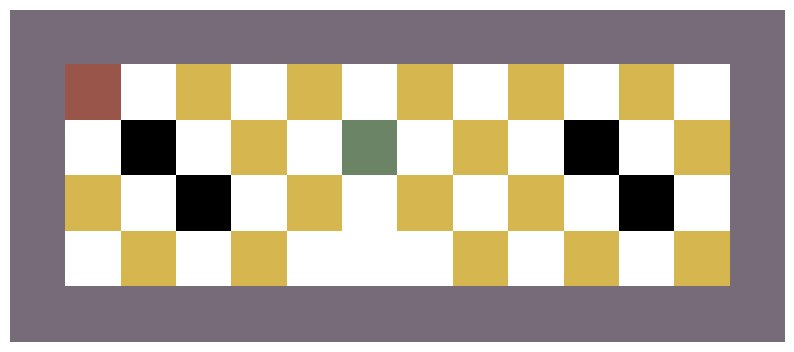

In [125]:
# Visualize the environment
plt.figure(figsize=(10, 10))

# #T-Maze Environment
# env = gym.make("LinearTrack-v0")
# _, obs_to_render = env.reset_with_render()
# env.render(obs_to_render)

# TODO: Deadly Gridworld 
env = gym.make("DeadlyGrid-v0")
_, obs_to_render = env.reset_with_render()
env.render(obs_to_render)

0


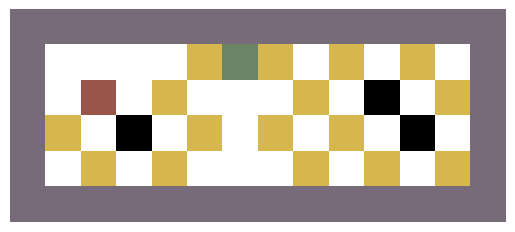

In [126]:
# Run random steps & Visualize the episode
from IPython import display

_, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
rew_total = 0
for i in range(25):
    action = env.action_space.sample()
    _, rew , done, _, obs_to_render = env.step_with_render(action)
    env.render(obs_to_render)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    rew_total += rew
    if done:
        break
print(rew_total)

# Part 2 - Deep Q-Learning Agents

In [127]:
import torch
import torch.nn as nn
import os
from collections import namedtuple
random_seed = 345
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)


In [128]:
# Define the MLP architecture
class Q_MLP(nn.Module):
    def __init__(self, env_type = 'Linear Track'):
        self.env_type = env_type
        super(Q_MLP, self).__init__()
        
        if self.env_type == 'Linear Track':
            input_size = 384 # 3 × 32 × 4
            output_dim = 3
        
        elif self.env_type == 'Deadly Grid':
            input_size = 420 # 6 × 14 × 5
            output_dim = 5
        
        else:
            raise NotImplementedError
        
        hidden_units = [128]
        layers = []
        
        # Add the hidden layers
        for units in hidden_units:
            layers.append(nn.Linear(input_size, units))
            layers.append(nn.ReLU())
            input_size = units
        
        # Add the output layer
        layers.append(nn.Linear(input_size, output_dim))
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)


In [129]:
class ShallowNet(nn.Module):
    def __init__(self, env_type = 'Linear Track'):
        self.env_type = env_type
        super(ShallowNet, self).__init__()
        
        if self.env_type == 'Linear Track':
            input_size = 384 # 3 × 32 × 4
            output_dim = 3
        
        elif self.env_type == 'Deadly Grid':
            input_size = 420 # 6 × 14 × 5
            output_dim = 5
        
        else:
            print('Invalid environment type')
            raise NotImplementedError
        
        layers = []
        layers.append(nn.Linear(input_size, output_dim))
        layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)


In [130]:
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = experience
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        batch = Experience(*zip(*experiences))
        return torch.stack(batch.state, dim=0) , torch.tensor(batch.action), torch.tensor(batch.reward), torch.stack(batch.next_state, dim=0) , torch.tensor(batch.done)

    def __len__(self):
        return len(self.buffer)


In [131]:
class Agent: 
    def __init__(self, env, env_type = 'Linear Track', loss_fn = "MSE", optimizer = "Adam", network_type = "MLP", batch_size=128, target_update = 500, buffer_size=1000, lr=0.001, gamma=0.99, eps_start=1.0, eps_end=0.01, update_steps=60_000, save = True):
        self.env = env
        self.update_steps = update_steps
        self.batch_size = batch_size
        self.target_update = target_update
        self.env_type = env_type
        self.lr = lr
        self.save = save
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.replay_buffer = ReplayBuffer(capacity=buffer_size)
        self.eps_threshold = self.eps_start   
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      
        self.set_network(network_type)
        self.set_optimizer(optimizer)
        self.set_loss_fn(loss_fn)
        self.set_save_directory()
            
        self.check_directory()
    
    def set_network(self, network_type):
        if network_type == "MLP":
           
            self.q_net = Q_MLP(env_type=self.env_type)
            self.target_net = Q_MLP(env_type=self.env_type)
            
        elif network_type == "Shallow":
           
            self.q_net = ShallowNet(env_type=self.env_type)
            self.target_net = ShallowNet(env_type=self.env_type)
        
        else:
            raise NotImplementedError('Invalid network type')
         
        self.target_net.load_state_dict(self.q_net.state_dict())
        
    def set_optimizer(self, optimizer):
        if optimizer == "Adam" and self.q_net != None:
            self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.lr)
        
        else:
            raise NotImplementedError('Invalid optimizer type')
        
    def set_loss_fn(self, loss_fn):
        if loss_fn == "MSE" : 
            self.loss_fn = nn.MSELoss()
            
        elif loss_fn == "Huber" :
            self.loss_fn = nn.SmoothL1Loss()
        
        else:
            raise NotImplementedError('Invalid loss function type')
        
    def set_save_directory(self):
        if self.env_type == 'Linear Track':
            self.save_directory = "/Linear/"
            
        elif self.env_type == 'Deadly Grid':
            self.save_directory = "/Grid/"
        
        else:
            raise NotImplementedError('Invalid environment type')
        
    def check_directory(self):
        directories = [f"./models/Replay{self.save_directory}", f"./models{self.save_directory}"]
        for path in directories:
            if not os.path.exists(path):
                os.makedirs(path)
                print(f"Directory '{path}' created successfully.")
    
    def save_model(self, filename):
        torch.save(self.q_net.state_dict(), filename)

    def load_model(self, filename):
        self.q_net.load_state_dict(torch.load(filename))
        self.q_net.eval()

    def roll_out(self, num_episodes = 10, epsilon = 0.01):
        rewards = []
        for _ in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0
            while not done:
                state_tensor = torch.flatten(torch.tensor(state, dtype=torch.float32))
                q_values = self.q_net(state_tensor)
                action = self.env.action_space.sample()  if random.random() < epsilon else torch.argmax(q_values).item() 
                next_state, rew , done, _ = self.env.step(action)
                episode_reward += rew
                state = next_state
            rewards.append(episode_reward)
            
        return rewards
    
    def evaluate(self, num_episodes = 10, epsilon = 0.01):
        rewards = []
        discounted_rewards = []
        for _ in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0
            discount = 1.0
            dis_reward = 0
            while not done:
                state_tensor = torch.flatten(torch.tensor(state, dtype=torch.float32))
                q_values = self.q_net(state_tensor)
                action = self.env.action_space.sample()  if random.random() < epsilon else torch.argmax(q_values).item() 
                next_state, rew , done, _ = self.env.step(action)
                episode_reward += rew
                dis_reward = dis_reward + (discount * rew)
                discount *= self.gamma
                state = next_state
            
            
            discounted_rewards.append(dis_reward)
            rewards.append(episode_reward)
            
        return np.mean(rewards), np.mean(discounted_rewards)
        
    def train_witout_replay(self):
        self.eps_threshold = self.eps_start   
        eval_rewards = []
        eval_rewards_discounted = []
        done = False
        state = self.env.reset()
        for update_step in range(1, self.update_steps + 1):
           
            if done:
                state = self.env.reset()
                done = False
                
            #State forward pass
            state_tensor = torch.flatten(torch.tensor(state, dtype=torch.float32)).to(self.device)
            q_values = self.q_net(state_tensor)
            
            #Greedily policy
            action = self.env.action_space.sample()  if random.random() < self.eps_threshold else torch.argmax(q_values).item() 
            
            #Step
            next_state, rew , done, _ = self.env.step(action)
        
            #Next State forward pass from target network
            next_state_tensor = torch.flatten(torch.tensor(next_state, dtype=torch.float32)).to(self.device)
            next_q_values = self.target_net(next_state_tensor).detach()
            max_next_q_value = torch.max(next_q_values)
            
            #Learning step
            target_q_value = rew + self.gamma * max_next_q_value * (1 - done)
            q_value = q_values[action]
            loss = self.loss_fn(q_value, target_q_value)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()        
                
            #Update state and increment step counter
            state = next_state

            #Update target network every 500 steps       
            if update_step % self.target_update == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())
                
            #Evaluate the policy every 1k steps
            if update_step % 1000 == 0:
                self.env.reset()
                average_reward, discounted_rew = self.evaluate()
                eval_rewards.append(average_reward)
                eval_rewards_discounted.append(discounted_rew)
                done = True
            
            if update_step % 20_000 == 0 and self.save:
                self.save_model(f"models{self.save_directory}dqn_model_gamma_{self.gamma}_episode_{update_step}.pth")

            #Epsilon anneal linear decay over the number of episodes    
            decay = self.eps_start - (update_step / (self.update_steps*.8)) * (self.eps_start - self.eps_end)
            self.eps_threshold = max(decay, self.eps_end)
           
        self.env.close()
        return self.q_net, eval_rewards,eval_rewards_discounted
    
    def train_with_replay(self):
        self.eps_threshold = self.eps_start   
        eval_rewards = []
        eval_rewards_discounted = []
        done = False
        state = self.env.reset()
        
        for update_step in range(1, self.update_steps + 1):
            
            if done:
                state = self.env.reset()
                done = False
              
            #State forward pass from q_net
            state_tensor = torch.flatten(torch.tensor(state, dtype=torch.float32)).to(self.device)
            q_values = self.q_net(state_tensor)
        
            #Greedily policy
            action = self.env.action_space.sample()  if random.random() < self.eps_threshold else torch.argmax(q_values).item() 
            
            #Step
            next_state, rew , done, _ = self.env.step(action)
            next_state_tensor = torch.flatten(torch.tensor(next_state, dtype=torch.float32)).to(self.device)
            
            #Store transition in replay buffer
          
            experience = Experience(state_tensor, action, rew, next_state_tensor, done)
            self.replay_buffer.push(experience)
            
            #Update state and increment step counter
            state = next_state
            
            #Update target network every 500 steps       
            if update_step % self.target_update == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())
            
            #Evaluate the policy every 1k steps
            if update_step % 1000 == 0:
                self.env.reset()
                average_reward, discounted_rew = self.evaluate()
                eval_rewards.append(average_reward)
                eval_rewards_discounted.append(discounted_rew)
                done = True
            
            if update_step % 20_000 == 0 and self.save:
                self.save_model(f"models/Replay{self.save_directory}dqn_model_gamma_{self.gamma}_episode_{update_step}.pth")
                

            #Epsilon anneal linear decay over the number of upgrade steps    
            decay = self.eps_start - (update_step / (self.update_steps*.8)) * (self.eps_start - self.eps_end)
            self.eps_threshold = max(decay, self.eps_end)
            
            if len(self.replay_buffer) >= self.batch_size: 
                state_batch, action_barch, reward_batch, next_state_batch, done_batch = self.replay_buffer.sample(self.batch_size)
               
                #Compute Q targets
                with torch.no_grad():
                    next_q_values = self.target_net(next_state_batch)
                    max_next_q_values = torch.max(next_q_values, dim=1).values
                    target_q_values = reward_batch + self.gamma * max_next_q_values *  (~done_batch)

                # Compute Q values and loss
                q_values = self.q_net(state_batch)
                q_values = q_values.gather(1, action_barch.unsqueeze(1)).squeeze(1)
                loss = self.loss_fn(q_values, target_q_values)

                # Update the model
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
        self.env.close()
        return self.q_net, eval_rewards, eval_rewards_discounted

## Evaluation with replay memory and without replay memory

The discount factor (a number between 0-1) is a clever way to scale down the rewards more and more after each step so that, the total sum remains bounded. The discounted sum of rewards is called return (
) in RL.

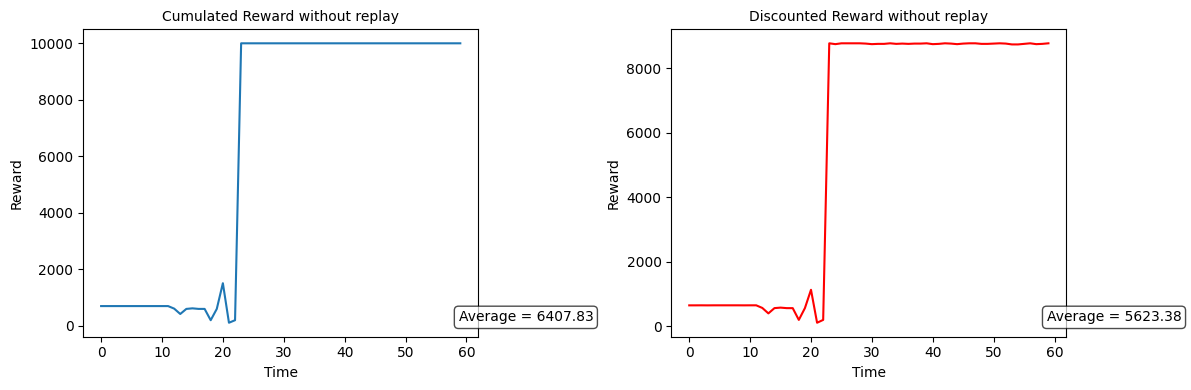

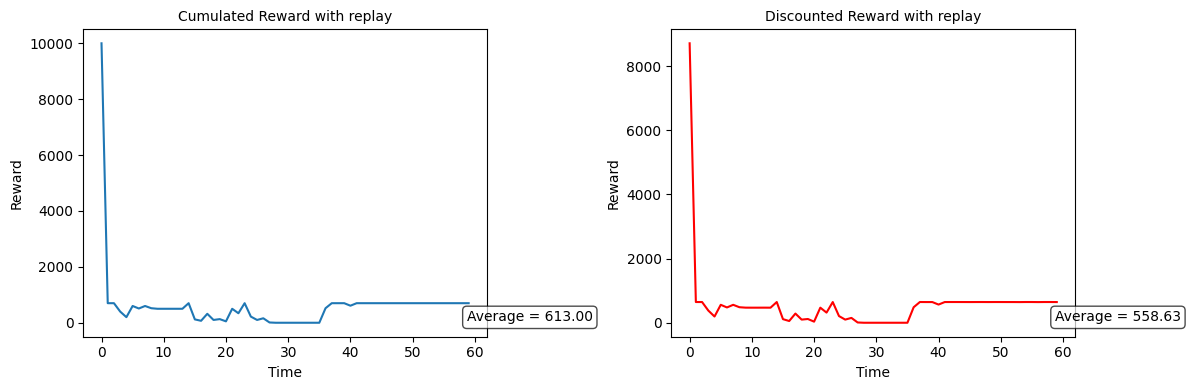

In [132]:
# Run for "LinearTrack-v0" 
env = gym.make("LinearTrack-v0")
env.seed(random_seed)
replay = [False, True]

for replay_activate in replay:
     agent = Agent(env, env_type = "Linear Track", update_steps=60_000, save=False)

     if replay_activate:
          title = 'with replay'
          qnet , eval_rewards, discounted_rew = agent.train_with_replay()
          
          
     elif not replay_activate:
          title = 'without replay'
          qnet , eval_rewards, discounted_rew = agent.train_witout_replay()
          

     # Plot the average reward over time
     plt.figure(figsize=(12, 4))
     plt.subplot(1, 2, 1)
     plt.plot(eval_rewards)
     average_label = f'Average = {np.mean(eval_rewards):.2f}'
     plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

     plt.xlabel('Time')
     plt.ylabel('Reward')
     plt.title(f'Cumulated Reward {title}', fontsize=10)

          # Plot the discounted reward over time
     plt.subplot(1, 2, 2)
     plt.plot(discounted_rew, color='red')
     average_label = f'Average = {np.mean(discounted_rew):.2f}'
     plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

     plt.xlabel('Time')
     plt.ylabel('Reward')
     plt.title(f'Discounted Reward {title}', fontsize=10)

     plt.tight_layout()
     plt.show()

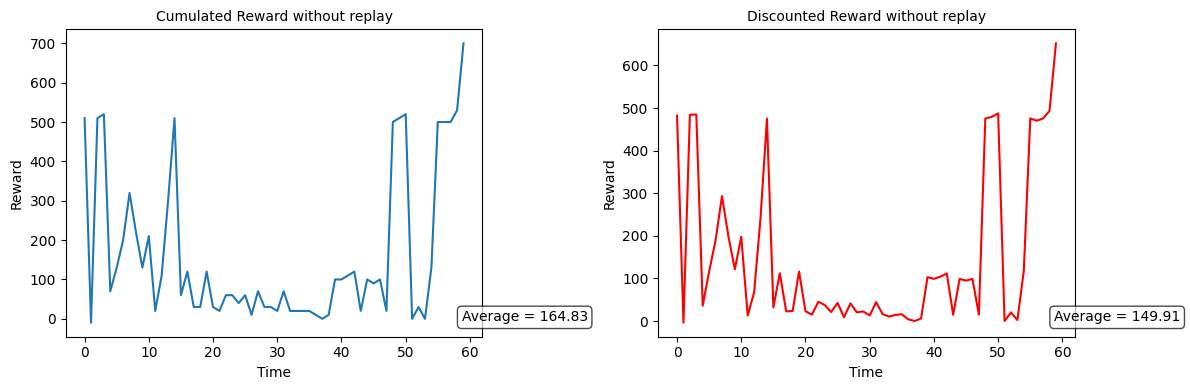

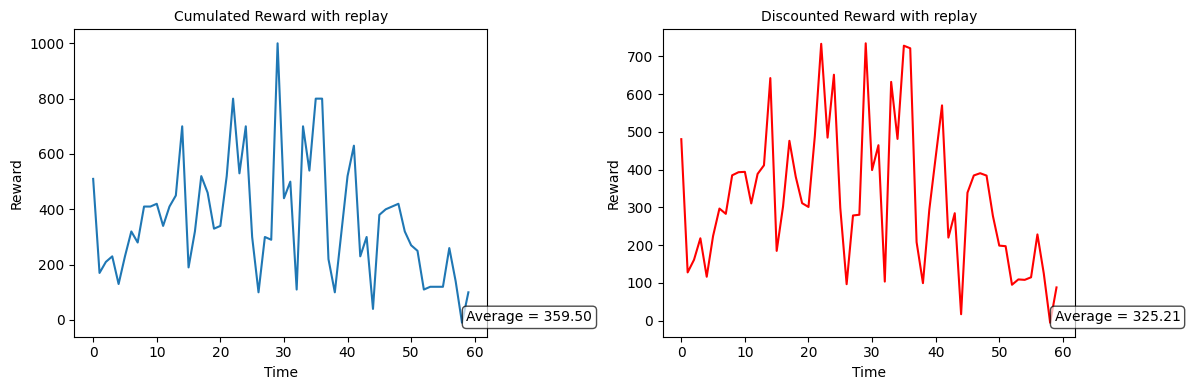

In [133]:
# Run for "DeadlyGrid-v0" 
env = gym.make("DeadlyGrid-v0")
env.seed(random_seed)
replay = [False, True]

for replay_activate in replay:
     agent = Agent(env, env_type = "Deadly Grid", update_steps=60_000, save=False)
     if replay_activate:
          title = 'with replay'
          qnet , eval_rewards, discounted_rew = agent.train_with_replay()
          
          
     elif not replay_activate:
          title = 'without replay'
          qnet , eval_rewards, discounted_rew = agent.train_witout_replay()
          

     # Plot the average reward over time
     plt.figure(figsize=(12, 4))
     plt.subplot(1, 2, 1)
     plt.plot(eval_rewards)
     average_label = f'Average = {np.mean(eval_rewards):.2f}'
     plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

     plt.xlabel('Time')
     plt.ylabel('Reward')
     plt.title(f'Cumulated Reward {title}', fontsize=10)

          # Plot the discounted reward over time
     plt.subplot(1, 2, 2)
     plt.plot(discounted_rew, color='red')
     average_label = f'Average = {np.mean(discounted_rew):.2f}'
     plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

     plt.xlabel('Time')
     plt.ylabel('Reward')
     plt.title(f'Discounted Reward {title}', fontsize=10)

     plt.tight_layout()
     plt.show()

## Behavioural Analysis

γ ∈ [0.7, 0.8, 0.9, 0.99]

In [134]:


def do_rollout(env_type = 'Linear Track', replay = False):
    discount_factors = [0.7, 0.8, 0.9, 0.99]
    replay_dir = "/replay/" if replay else "/"
    replay_title = "with replay" if replay else ""
    
    if env_type == 'Linear Track':
        env = gym.make("LinearTrack-v0")
        directory_path = f'./models{replay_dir}Linear'
        
    elif env_type == 'Deadly Grid':
        env = gym.make("DeadlyGrid-v0")
        directory_path = f'./models{replay_dir}Grid'
            
    # Get all file names in the directory
    file_names = os.listdir(directory_path)
    
    env.seed(random_seed)
    agent = Agent(env, env_type = env_type, save=False)

    for gamma in discount_factors:
        filtered_list = [file_name for file_name in file_names if f'gamma_{gamma}_' in file_name]
        episodes_rewards = []
        for item in filtered_list:
            agent.load_model(f"{directory_path}/{item}")
            rewards = agent.roll_out()
            episodes_rewards.append(rewards)
        
        plt.figure()
        plt.title(f"{env_type} {replay_title} - Gamma: {gamma}")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        
        # Plot the results
        for i,rew in enumerate(episodes_rewards):
            update_step = int((i+1) * 20000)
            plt.plot(rew, label=f"At update step {update_step}")
            
        plt.legend(loc='best')
        plt.show()

In [135]:
# Run for "LinearTrack-v0" 
env = gym.make("LinearTrack-v0")
env.seed(random_seed)
discount_factors = [0.7, 0.8, 0.9, 0.99]
replay = [False, True]

for replay_activate in replay:
     for gamma in discount_factors:
          agent = Agent(env, env_type = "Linear Track", gamma=gamma, update_steps=60_000)
          if replay_activate:
               agent.train_with_replay()
          
          elif not replay_activate:
               agent.train_witout_replay()
     

Evaluate

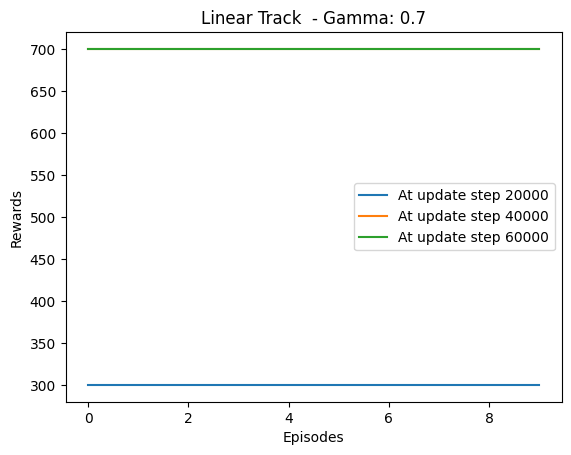

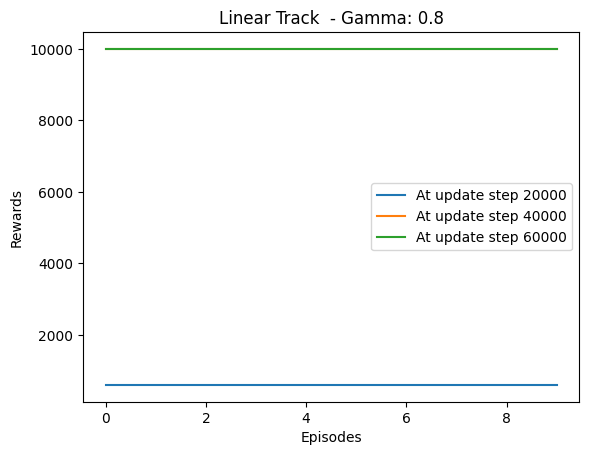

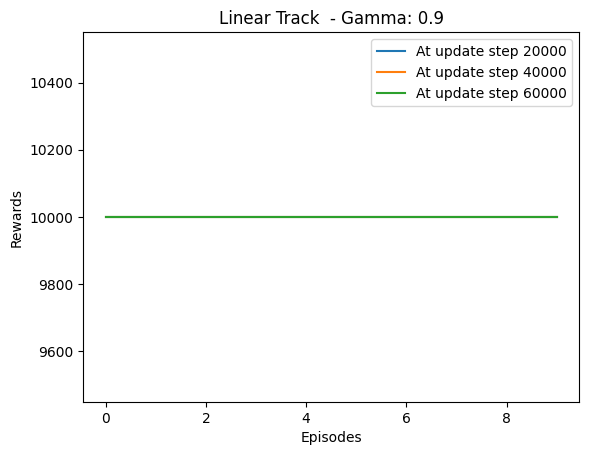

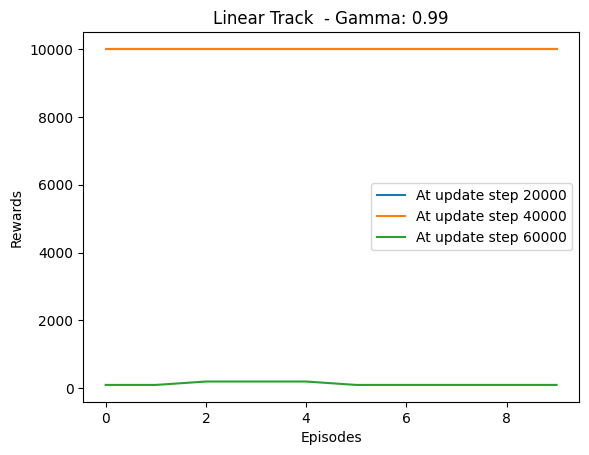

In [136]:
do_rollout(env_type='Linear Track', replay=False)

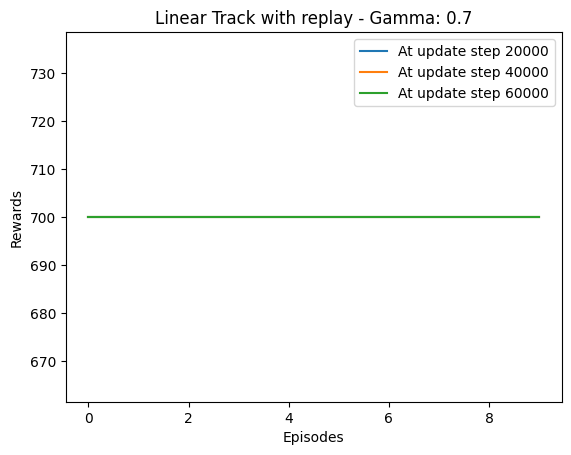

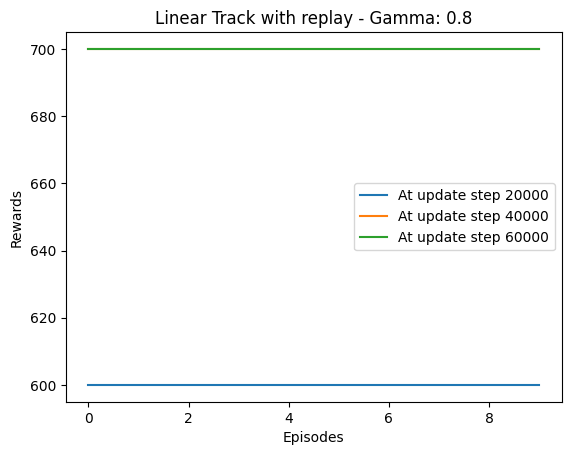

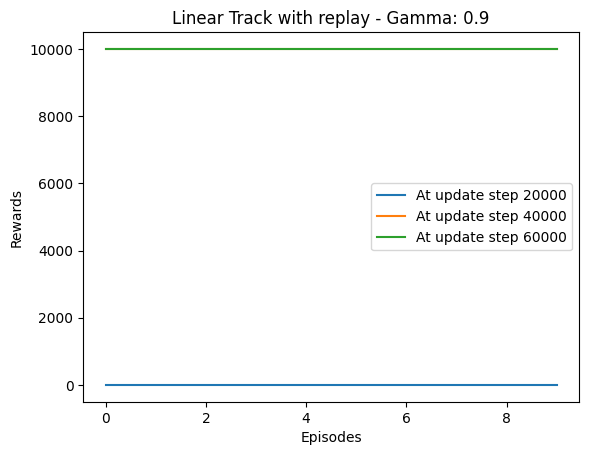

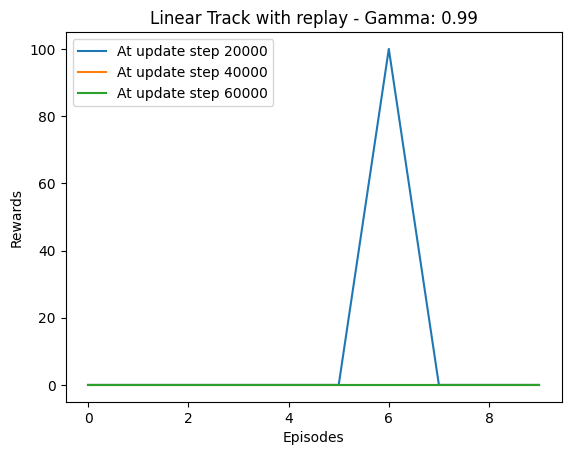

In [137]:
do_rollout(env_type='Linear Track', replay=True)

In [138]:
# Run for "DeadlyGrid-v0" 
env = gym.make("DeadlyGrid-v0")
env.seed(random_seed)
discount_factors = [0.7, 0.8, 0.9, 0.99]
replay = [False, True]

for replay_activate in replay:
     for gamma in discount_factors:
          agent = Agent(env, env_type ="Deadly Grid", gamma=gamma, update_steps=60_000)
          if replay_activate:
               agent.train_with_replay()
          
          elif not replay_activate:
               agent.train_witout_replay()

Evaluate

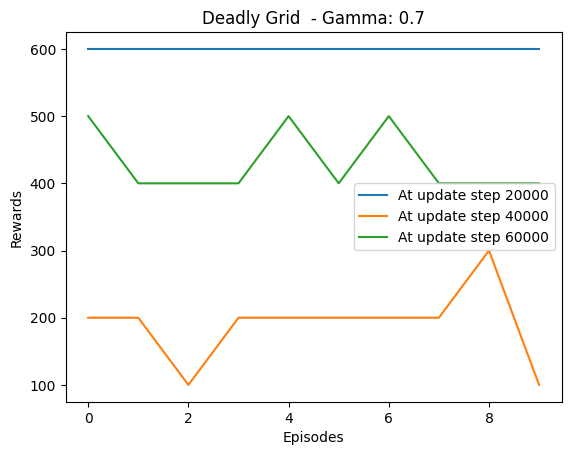

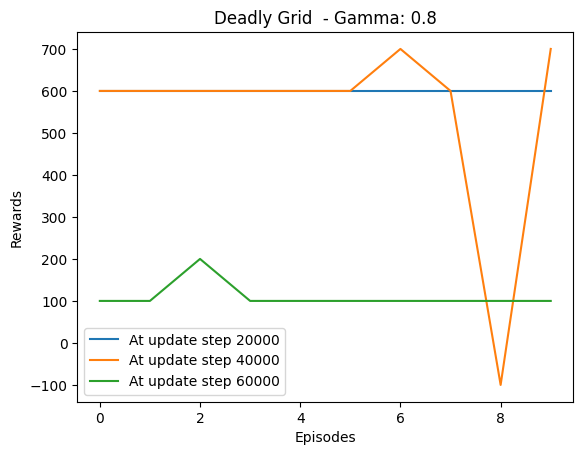

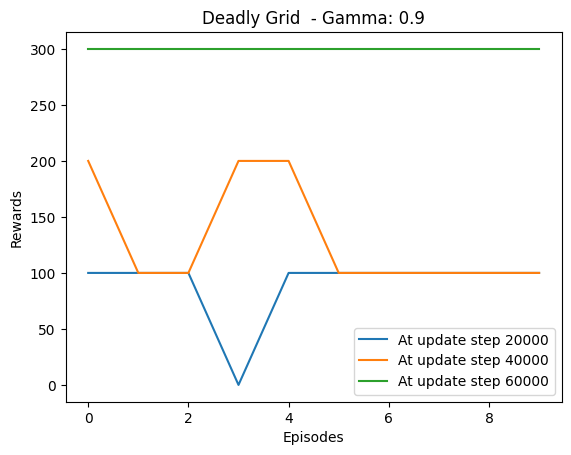

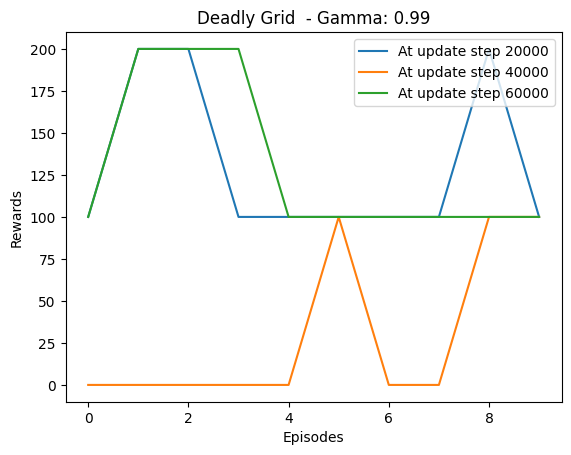

In [139]:
do_rollout(env_type="Deadly Grid", replay=False)

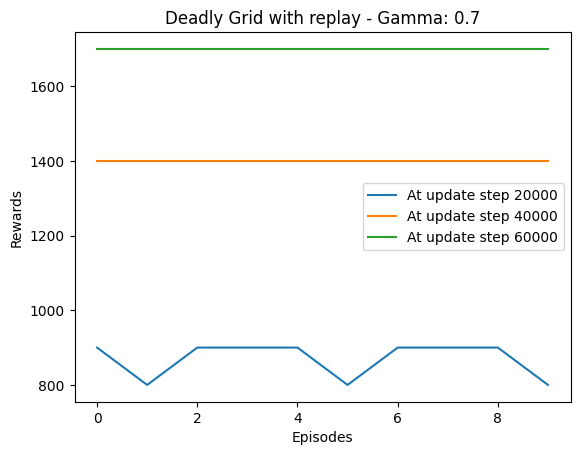

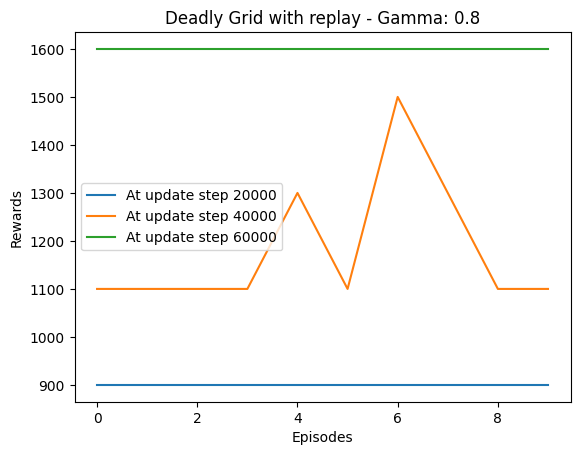

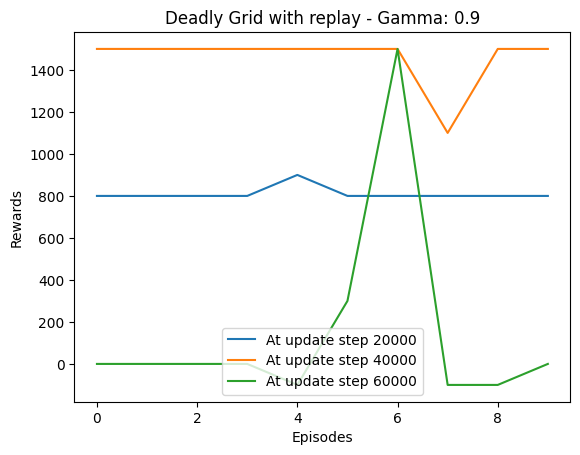

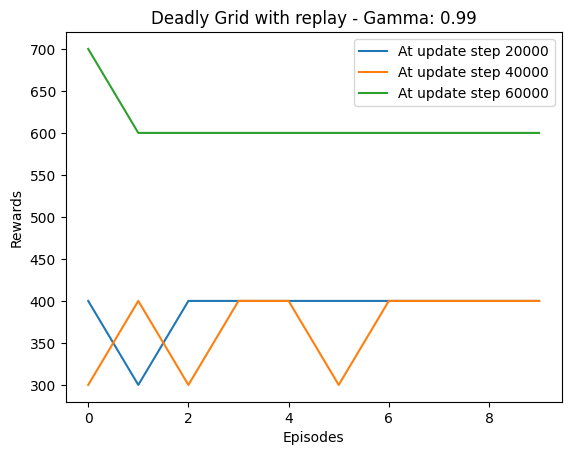

In [140]:
do_rollout(env_type="Deadly Grid", replay=True)

## Loss Function Comparison

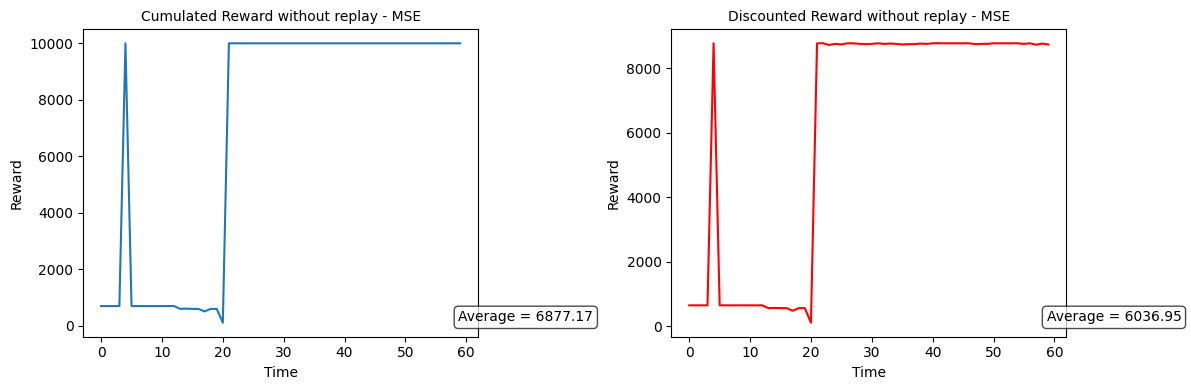

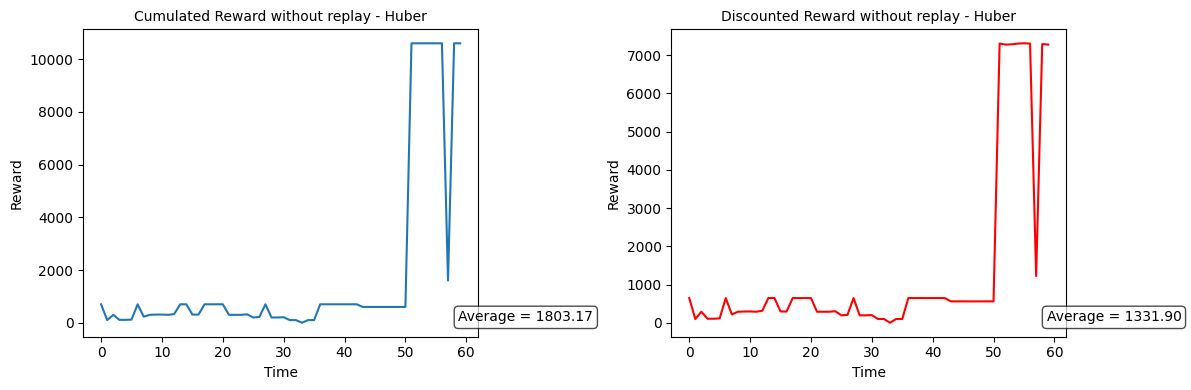

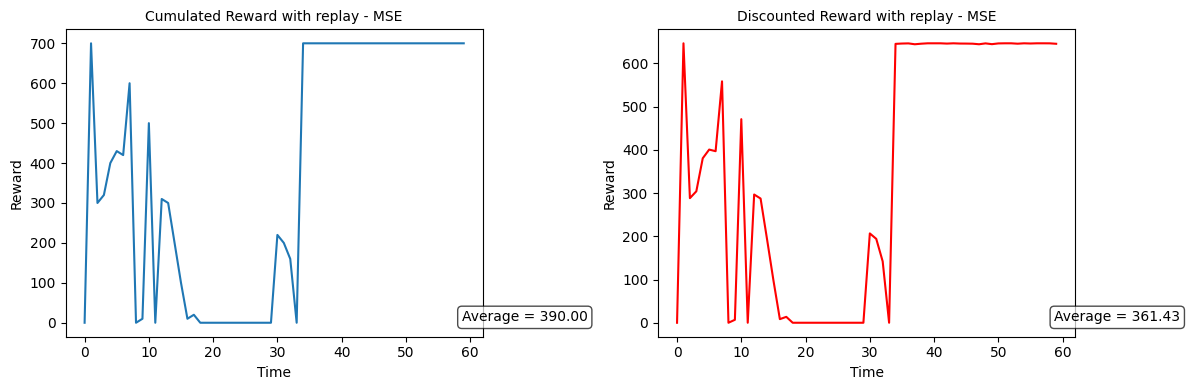

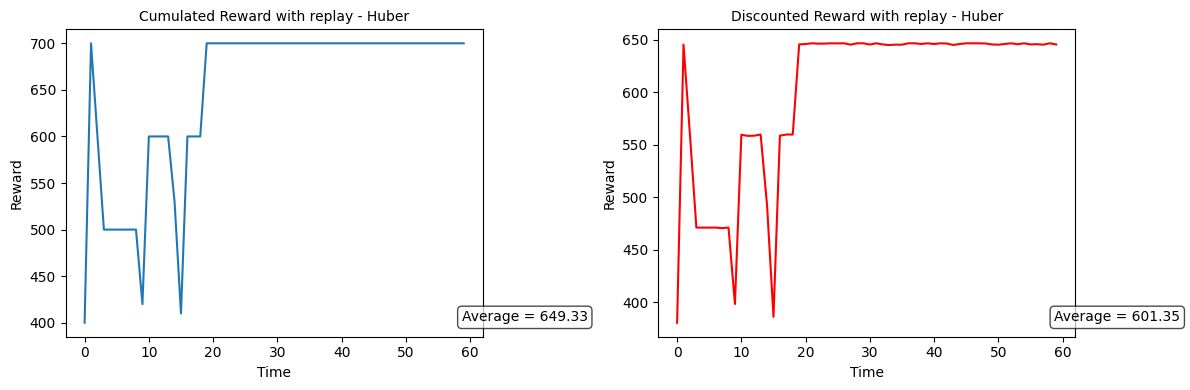

In [141]:
# Run for "LinearTrack-v0" 
env = gym.make("LinearTrack-v0")
env.seed(random_seed)
loss_fn = ["MSE", "Huber"]
replay = [False, True]
for replay_activate in replay:
        for loss in loss_fn:
                agent = Agent(env, env_type = "Linear Track", loss_fn=loss,update_steps=60_000, save=False)
                if replay_activate:
                        title = f'with replay - {loss}'
                        qnet , eval_rewards, discounted_rew = agent.train_with_replay()
                        
                        
                elif not replay_activate:
                        title = f'without replay - {loss}'
                        qnet , eval_rewards, discounted_rew = agent.train_witout_replay()

                # Plot the average reward over time
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.plot(eval_rewards)
                average_label = f'Average = {np.mean(eval_rewards):.2f}'
                plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

                plt.xlabel('Time')
                plt.ylabel('Reward')
                plt.title(f'Cumulated Reward {title}', fontsize=10)

                # Plot the discounted reward over time
                plt.subplot(1, 2, 2)
                plt.plot(discounted_rew, color='red')
                average_label = f'Average = {np.mean(discounted_rew):.2f}'
                plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

                plt.xlabel('Time')
                plt.ylabel('Reward')
                plt.title(f'Discounted Reward {title}', fontsize=10)

                plt.tight_layout()
                plt.show()

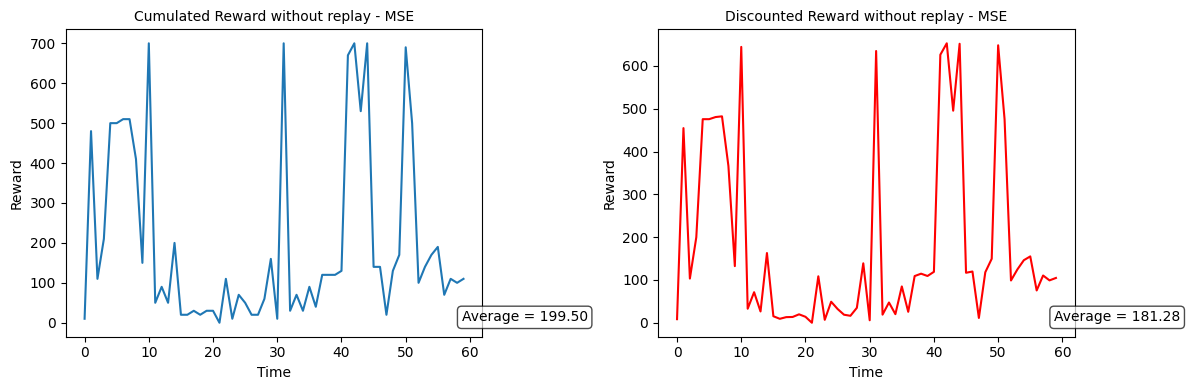

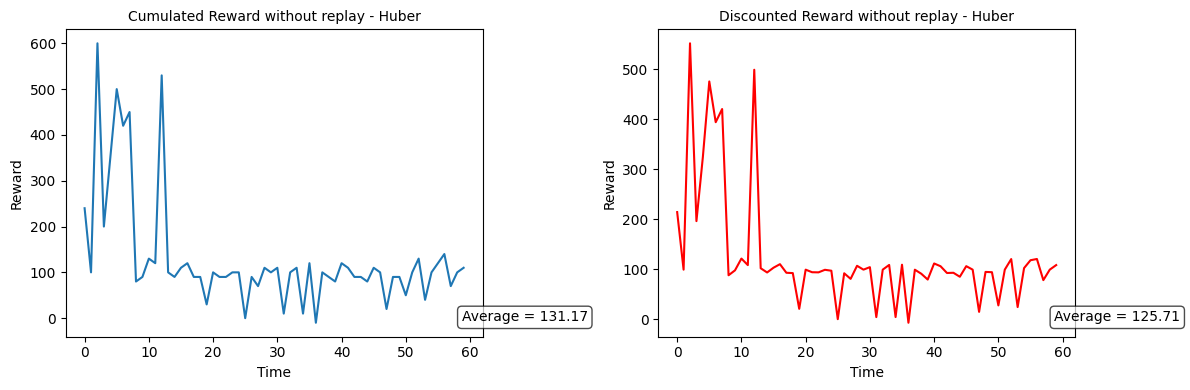

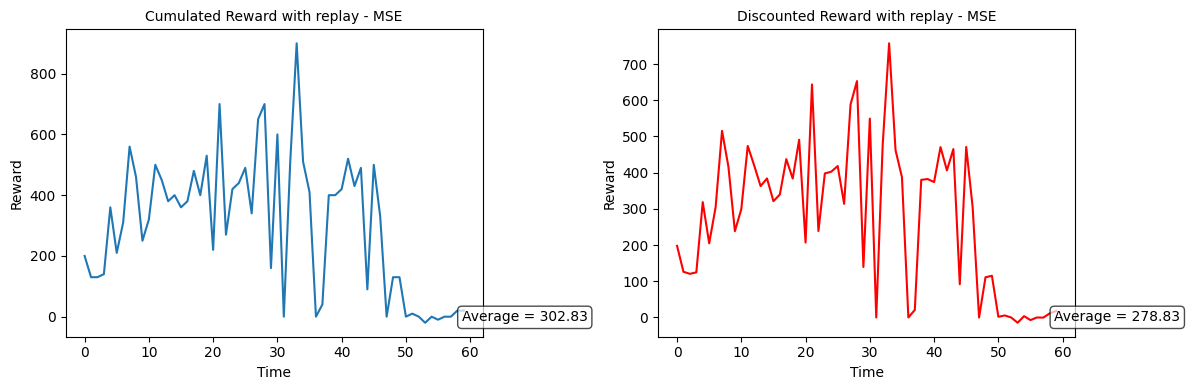

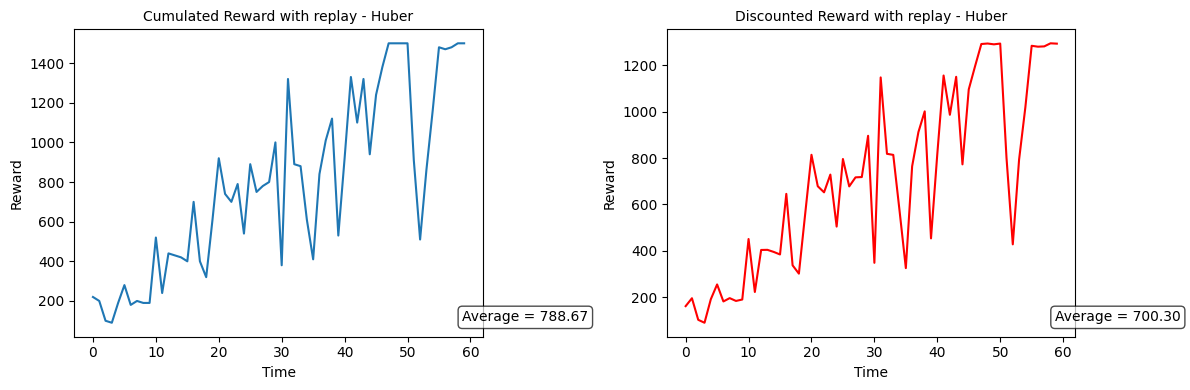

In [142]:
# Run for "DeadlyGrid-v0" 
env = gym.make("DeadlyGrid-v0")
env.seed(random_seed)
loss_fn = ["MSE", "Huber"]
replay = [False, True]
for replay_activate in replay:
        for loss in loss_fn:
                agent = Agent(env, env_type = "Deadly Grid", loss_fn=loss,update_steps=60_000, save=False)
                if replay_activate:
                        title = f'with replay - {loss}'
                        qnet , eval_rewards, discounted_rew = agent.train_with_replay()
                        
                        
                elif not replay_activate:
                        title = f'without replay - {loss}'
                        qnet , eval_rewards, discounted_rew = agent.train_witout_replay()

                # Plot the average reward over time
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.plot(eval_rewards)
                average_label = f'Average = {np.mean(eval_rewards):.2f}'
                plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

                plt.xlabel('Time')
                plt.ylabel('Reward')
                plt.title(f'Cumulated Reward {title}', fontsize=10)

                        # Plot the discounted reward over time
                plt.subplot(1, 2, 2)
                plt.plot(discounted_rew, color='red')
                average_label = f'Average = {np.mean(discounted_rew):.2f}'
                plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

                plt.xlabel('Time')
                plt.ylabel('Reward')
                plt.title(f'Discounted Reward {title}', fontsize=10)

                plt.tight_layout()
                plt.show()

## Hyperparameter Intuition

Variation in learning rate

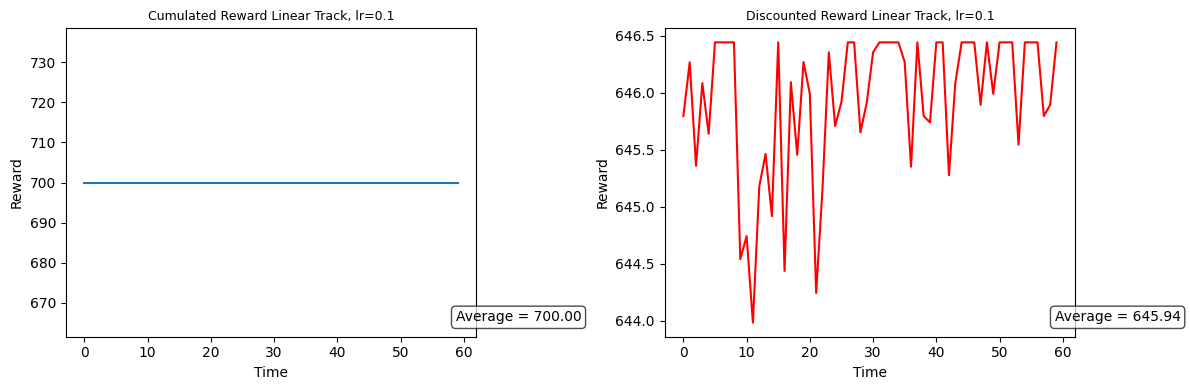

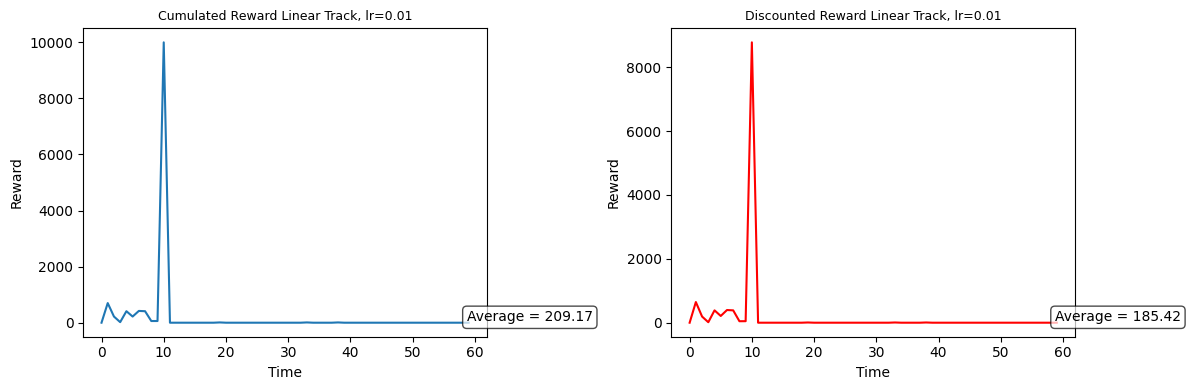

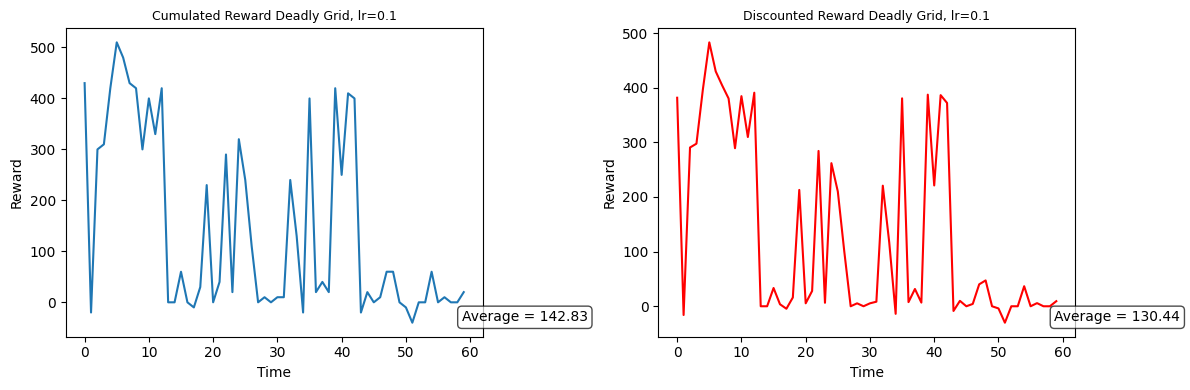

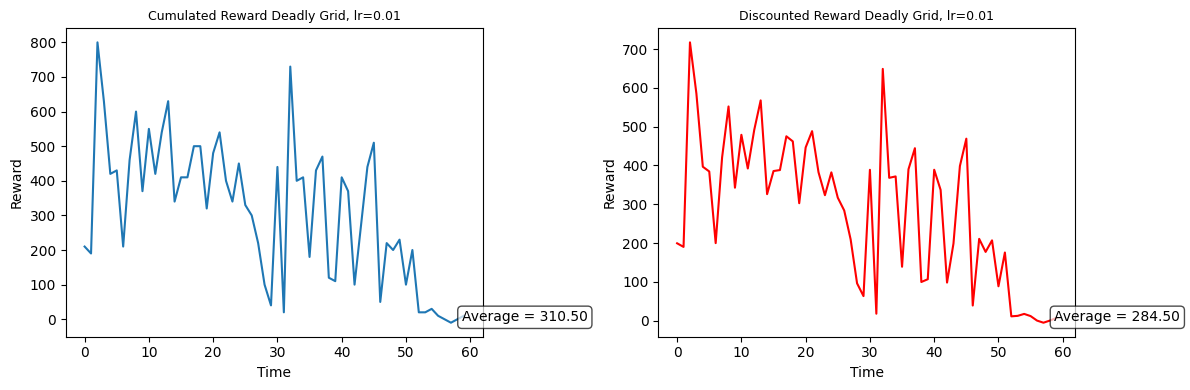

In [143]:
learning_rate = [0.1, 0.01]
env_types = ["Linear Track", "Deadly Grid"]
for env_type in env_types:
     
     if env_type == "Linear Track":
               env = gym.make("LinearTrack-v0")
               env.seed(random_seed)

     elif env_type == "Deadly Grid":
               env = gym.make("DeadlyGrid-v0")
               env.seed(random_seed)
                
     for lr_rate in learning_rate: 
          agent = Agent(env, env_type =env_type, lr=lr_rate, update_steps=60_000, save=False)
          qnet , eval_rewards, discounted_rew = agent.train_with_replay()
          
          title = f"{env_type}, lr={lr_rate}"
          
          # Plot the average reward over time
          plt.figure(figsize=(12, 4))
          plt.subplot(1, 2, 1)
          plt.plot(eval_rewards)
          average_label = f'Average = {np.mean(eval_rewards):.2f}'
          plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

          plt.xlabel('Time')
          plt.ylabel('Reward')
          plt.title(f'Cumulated Reward {title}', fontsize=9)

               # Plot the discounted reward over time
          plt.subplot(1, 2, 2)
          plt.plot(discounted_rew, color='red')
          average_label = f'Average = {np.mean(discounted_rew):.2f}'
          plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

          plt.xlabel('Time')
          plt.ylabel('Reward')
          plt.title(f'Discounted Reward {title}', fontsize=9)

          plt.tight_layout()
          plt.show()

Variation in batch size

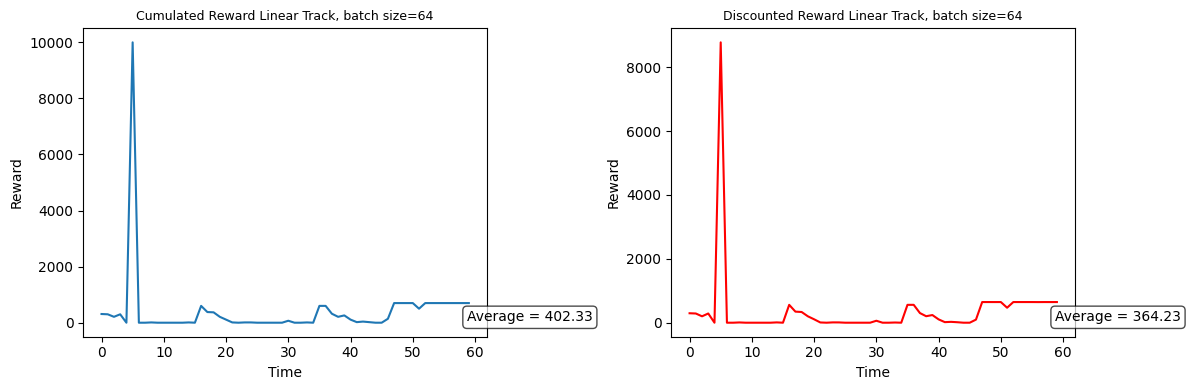

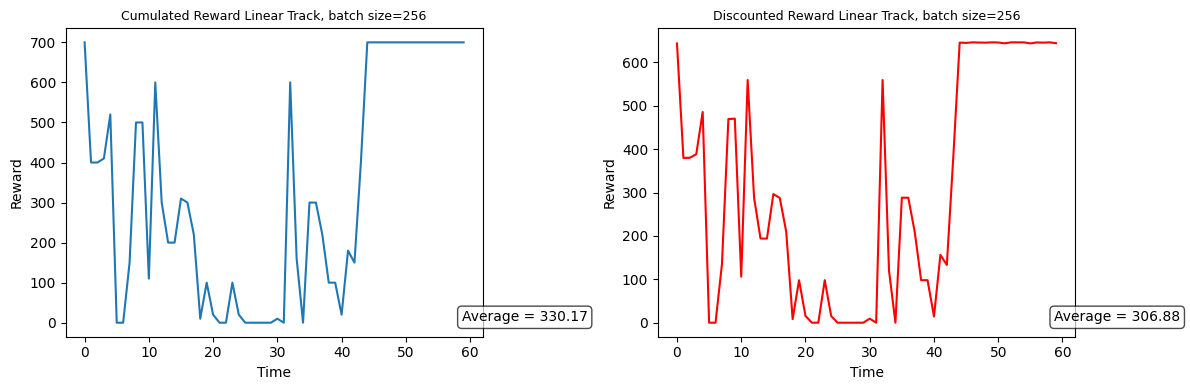

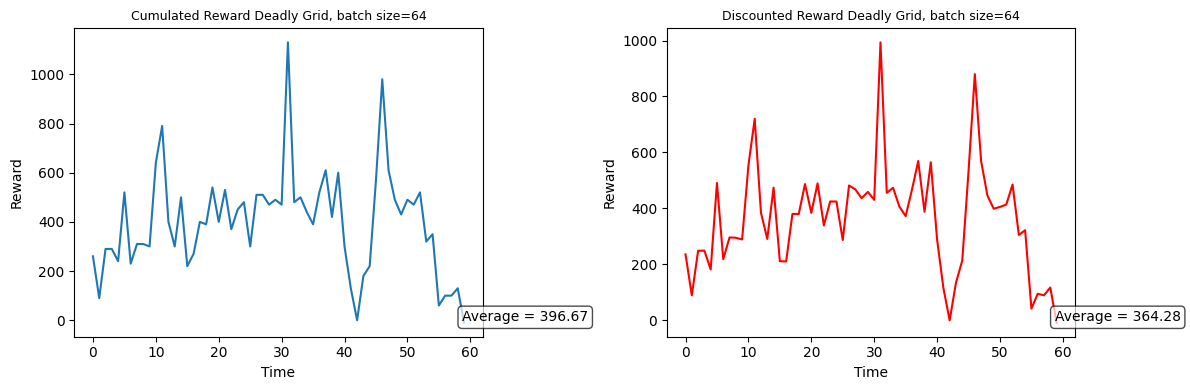

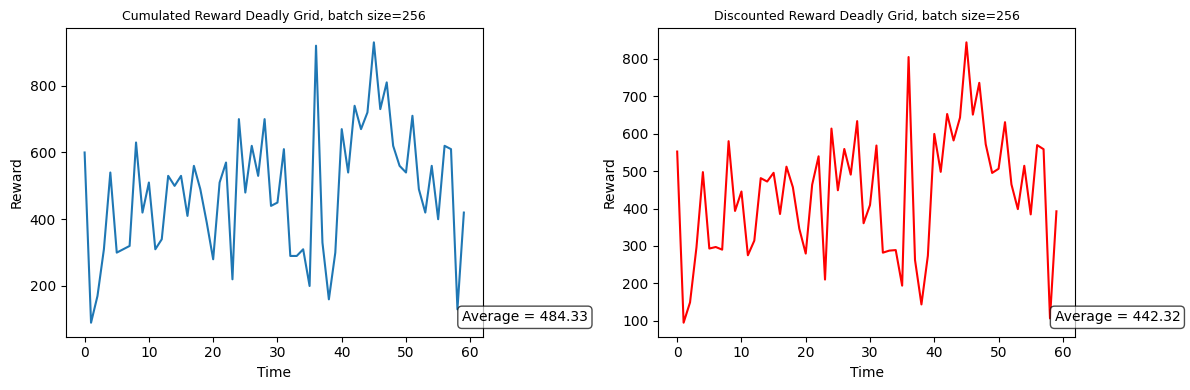

In [144]:
batch_size = [64, 256]
env_types = ["Linear Track", "Deadly Grid"]
for env_type in env_types:
     
     if env_type == "Linear Track":
               env = gym.make("LinearTrack-v0")
               env.seed(random_seed)

     elif env_type == "Deadly Grid":
               env = gym.make("DeadlyGrid-v0")
               env.seed(random_seed)
               
     for bt_size in batch_size:
          agent = Agent(env, env_type =env_type, batch_size=bt_size, update_steps=60_000, save=False)
          qnet , eval_rewards, discounted_rew = agent.train_with_replay()
          
          title = f"{env_type}, batch size={bt_size}"
          
          # Plot the average reward over time
          plt.figure(figsize=(12, 4))
          plt.subplot(1, 2, 1)
          plt.plot(eval_rewards)
          average_label = f'Average = {np.mean(eval_rewards):.2f}'
          plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

          plt.xlabel('Time')
          plt.ylabel('Reward')
          plt.title(f'Cumulated Reward {title}', fontsize=9)

               # Plot the discounted reward over time
          plt.subplot(1, 2, 2)
          plt.plot(discounted_rew, color='red')
          average_label = f'Average = {np.mean(discounted_rew):.2f}'
          plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

          plt.xlabel('Time')
          plt.ylabel('Reward')
          plt.title(f'Discounted Reward {title}', fontsize=9)

          plt.tight_layout()
          plt.show()

Shallow network

C:\Users\omare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pycolab\ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


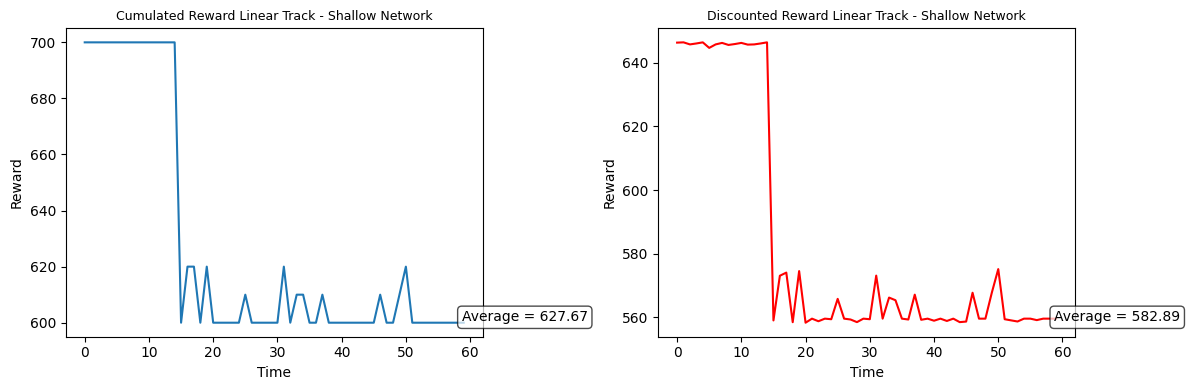

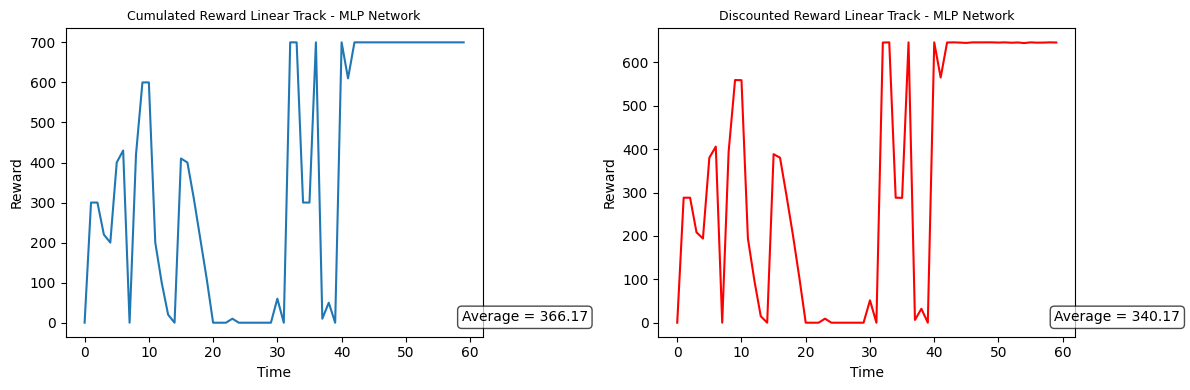

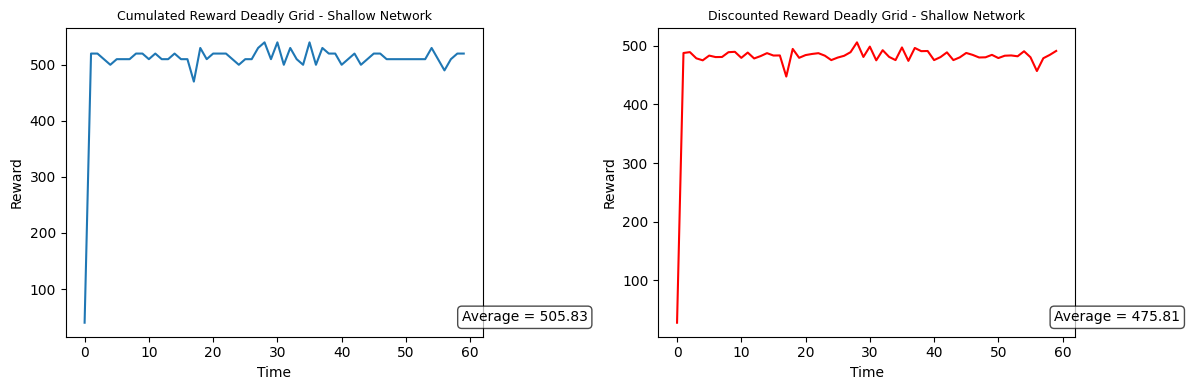

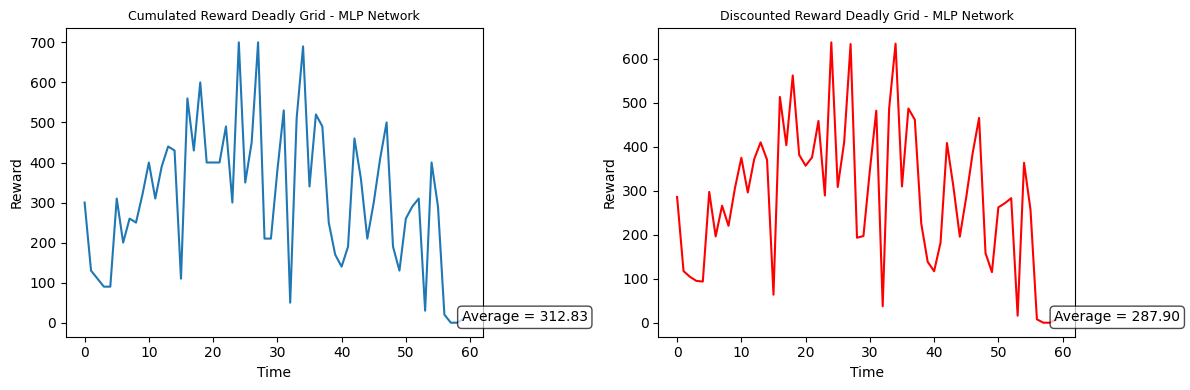

In [148]:

env_types = ["Linear Track", "Deadly Grid"]
network_types = ["Shallow", "MLP"]
for env_type in env_types:

        if env_type == "Linear Track":
                env = gym.make("LinearTrack-v0")
                env.seed(random_seed)

        elif env_type == "Deadly Grid":
                env = gym.make("DeadlyGrid-v0")
                env.seed(random_seed)

        for nwt in network_types:
                agent = Agent(env, env_type=env_type , network_type= nwt,  update_steps=60_000, save=False) 
                qnet , eval_rewards, discounted_rew = agent.train_with_replay()
                
                title = f"{env_type} - {nwt} Network"
                
                # Plot the average reward over time
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.plot(eval_rewards)
                average_label = f'Average = {np.mean(eval_rewards):.2f}'
                plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

                plt.xlabel('Time')
                plt.ylabel('Reward')
                plt.title(f'Cumulated Reward {title}', fontsize=9)

                        # Plot the discounted reward over time
                plt.subplot(1, 2, 2)
                plt.plot(discounted_rew, color='red')
                average_label = f'Average = {np.mean(discounted_rew):.2f}'
                plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

                plt.xlabel('Time')
                plt.ylabel('Reward')
                plt.title(f'Discounted Reward {title}', fontsize=9)

                plt.tight_layout()
                plt.show()

Variation in target network update frequency

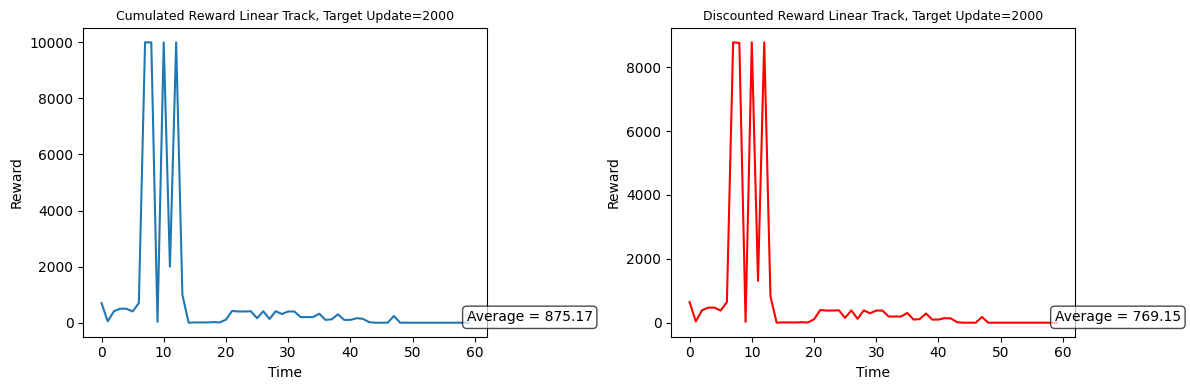

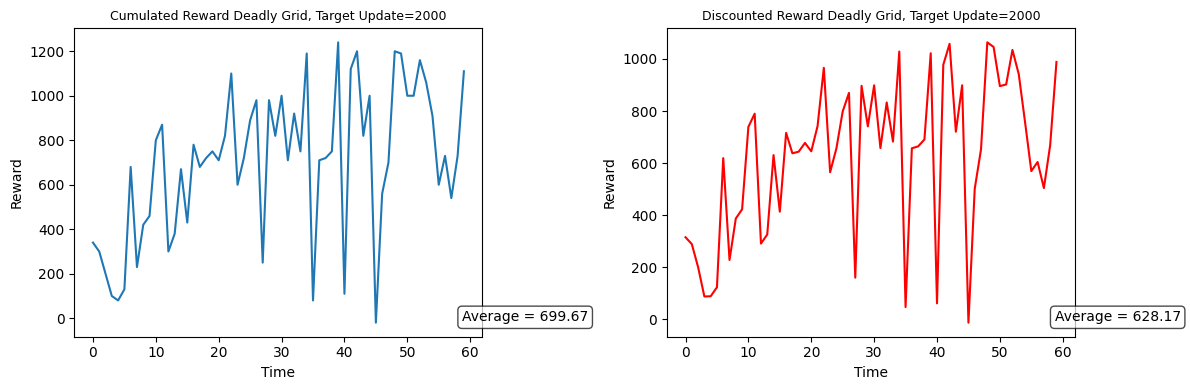

In [146]:
target_update = 2_000
env_types = ["Linear Track", "Deadly Grid"]

for env_type in env_types:
    
    if env_type == "Linear Track":
            env = gym.make("LinearTrack-v0")
            env.seed(random_seed)

    elif env_type == "Deadly Grid":
            env = gym.make("DeadlyGrid-v0")
            env.seed(random_seed)
                
    agent = Agent(env, env_type =env_type, target_update=target_update, update_steps=60_000, save=False)
    qnet , eval_rewards, discounted_rew = agent.train_with_replay()

    title = f"{env_type}, Target Update={target_update}"

    # Plot the average reward over time
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_rewards)
    average_label = f'Average = {np.mean(eval_rewards):.2f}'
    plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.xlabel('Time')
    plt.ylabel('Reward')
    plt.title(f'Cumulated Reward {title}', fontsize=9)

        # Plot the discounted reward over time
    plt.subplot(1, 2, 2)
    plt.plot(discounted_rew, color='red')
    average_label = f'Average = {np.mean(discounted_rew):.2f}'
    plt.text(0.95, 0.05, average_label, transform=plt.gca().transAxes,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.xlabel('Time')
    plt.ylabel('Reward')
    plt.title(f'Discounted Reward {title}', fontsize=9)

    plt.tight_layout()
    plt.show()